In [2]:
import platform
import warnings
import collections
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from konlpy.tag import Okt
from matplotlib import rc
from gensim.models import Word2Vec

warnings.filterwarnings(action='ignore')


In [3]:
class check_data():
    def __init__(self,df):
        self.df = df
        self.wiki_model = Word2Vec.load('../ko/ko.bin')
        if platform.system() == 'Windows':
            self.font = 'Malgun Gothic'
        else:
            self.font = 'NanumGothic'

        self.eff = self.df.columns[1]
        self.df[f'{self.eff}_Morps'] = self.df[self.eff].map(lambda x: self.getMorps(x))
        self.df[f'{self.eff}_NV'] = self.df[f'{self.eff}_Morps'].map(lambda x: self.getNV(x))
        self.df[f'{self.eff}_N'] = self.df[f'{self.eff}_Morps'].map(lambda x: self.getN(x))
  
    def topn(self,n):
        self.df[f'{self.eff}_count_topn_NV']  = self.df[f'{self.eff}_NV'].map(lambda x: self.counter(x,n)) 
        self.df[f'{self.eff}_count_topn_N']  = self.df['{self.eff}_N'].map(lambda x: self.counter(x,n)) 

    def getMorps(self,sent):
        return Okt().pos(sent , norm=False , stem = True) 

    def getNV(self, morps):
        stop_words = "하다 것 등 수 그 이 더욱 대해 예 머 매 내 수도 무엇 모든 이다 때 곧 식 또한 좀 꼭 번 해 과 바로 더욱 논 보이 난 "
        stop_words = set(stop_words.split(' '))

        result = []
        for item , morp in morps:
            if morp == 'Verb' or morp == 'Noun': 
                result.append(item)
        s_result = []
        
        for word in result:
            if word not in stop_words:
                s_result.append(word)
        return s_result
    
    def getN(self, morps):
        stop_words = "하다 것 등 수 그 이 더욱 대해 예 머 매 내 수도 무엇 모든 이다 때 곧 식 또한 좀 꼭 번 해 과 바로 더욱 논 보이 난 "

        stop_words = set(stop_words.split(' '))

        result = []
        for item , morp in morps:
            if morp == 'Noun': 
                result.append(item)
        s_result = []
        
        for word in result:
            if word not in stop_words:
                s_result.append(word)
        s_result = np.unique(s_result)
        return s_result

    def counter(self,sents, n):
        return sorted(collections.Counter(sents),reverse=True)[0:n]

    def get_heatmap(self, idx,figsize):
        energy = ['정열', '활기', '기력', '생기', '활발','--']
        recovery = ['낫' '치료', '쉼' ,'극복' , '재활', '--']
        cycle = ['돌', '유지', '조절' , '공급' ,'생명', '--']
        pury = ['진정' , '맑' , '없애' , '깨끗', '해소', '--']        
        all_dims = energy + recovery + cycle + pury
        #effs_dims_name = ['에너지', '회복', '순환', '정화']

        plt.rc('font', family=self.font)
        sents = self.df[f'{self.eff}_NV'][idx]
        
        result = []
        for word in sents:
            sub = []
            for dim_word in all_dims:
                try:
                    sub.append(self.wiki_model.wv.similarity(dim_word , word))
                except:
                    sub.append(0)
            result.append(sub)
        act_name = self.df['action'][idx]
        fig = plt.figure(figsize=figsize)
        fig.set_facecolor('white')
        plt.title(f'{act_name}에서 단어들간의 유사도 확인')
        sns.heatmap(result,annot=True)
        plt.xticks(np.arange(len(all_dims)),all_dims)
        plt.yticks(np.arange(len(sents)),sents)
        plt.show()
        
    def getDF(self):
        self.df.to_csv('data.csv')
        return self.df

    def result(self,idx, top , dis):
        energy = ['정열', '활기', '기력', '생기', '활발','--']
        recovery = ['낫' '치료', '쉼' ,'극복' , '재활', '--']
        cycle = ['돌', '유지', '조절' , '공급' ,'생명', '--']
        pury = ['진정' , '맑' , '없애' , '깨끗', '해소', '--']        
        effs_dims_name = ['에너지', '회복', '순환', '정화']
        effs_dims =  [energy, recovery, cycle , pury]
        sNV = self.df[f'{self.eff}_NV'][idx]

        result = []
        for dim in effs_dims:
            ab = []
            for sim_word in dim:
                sub = []
                for word in sNV:
                    try:
                        sub.append(self.wiki_model.wv.similarity(sim_word , word))
                    except:
                        sub.append(0)
                ab.append(sub)
                aab = np.array(ab).flatten().tolist()
            aab = np.array(sorted(aab,reverse=True))[:top].mean()
            result.append(aab)
            

        if dis == True:
            from matplotlib import rc
            plt.rc('font', family=self.font)

            word = self.df.iloc[idx][0]

            plt.figure()
            plt.bar(np.arange(len(result)),result)
            plt.title(f'{word}\'s mapping for top {top} using 유사어')
            plt.xticks(np.arange(len(effs_dims_name)), effs_dims_name)
            plt.yticks(np.arange(0,1.1,0.1))
            plt.show()
        return result

    def todf(self, topn, file_name):
        ret_df  = pd.DataFrame(columns=['감정','에너지','회복','순환','정화'])
        em = []
        est_e= []
        est_h= []
        est_c= []
        est_p= []
        
        for idx in self.df.index:
            em.append(self.df['action'][idx])
            est = self.result(idx,topn,False)
            est_e.append(est[0])        
            est_h.append(est[1])        
            est_c.append(est[2])        
            est_p.append(est[3])
        ret_df['감정'] = em        
        ret_df['에너지'] = est_e
        ret_df['회복'] = est_h
        ret_df['순환'] = est_c
        ret_df['정화'] = est_p
        
        ret_df.to_csv(file_name,index=False)
        return ret_df

In [17]:
# 차원의 유사어 - wiki 데이터에서는 동사에서 `다`를 뺀 단어로 들어가 있음 
model = Word2Vec.load('../ko/ko.bin')
print(model.wv.most_similar('없애',topn=2))
model.wv.most_similar('없애다',topn=2)

[('무너뜨리', 0.6106720566749573), ('제거', 0.6088800430297852)]


KeyError: "word '없애다' not in vocabulary"

In [4]:
# 동사에서 '다' 제거
energy = ['정열', '활기', '기력', '생기', '활발','--']
recovery = ['낫' '치료', '쉼' ,'극복' , '재활', '--']
cycle = ['돌', '유지', '조절' , '공급' ,'생명', '--']
pury = ['진정' , '맑' , '없애' , '깨끗', '해소', '--']        


In [5]:
# 행동 데이터 확인
dir = "../data/action_keyword_data.csv"
data = pd.read_csv(dir)
data

,action,효능
0,명상,마음 긍정 정신 안정 휴식
1,산책,기분 소화 예방 창의 해소
2,등산,근력 호흡 면역 강화 체중
3,샤워,피부 순환 배출 수면 활력
4,수영,근력 지구력 운동 재활 수면
5,조깅,관리 호흡 체중 면역 활력
6,자전거 타기,하체 체중 관절 근력 활력
7,요가,유연 균형 호흡 자세 안정
8,스트레칭,방지 회복 이완 탄력 균형
9,여행,활력 해방 교류 도전 기분


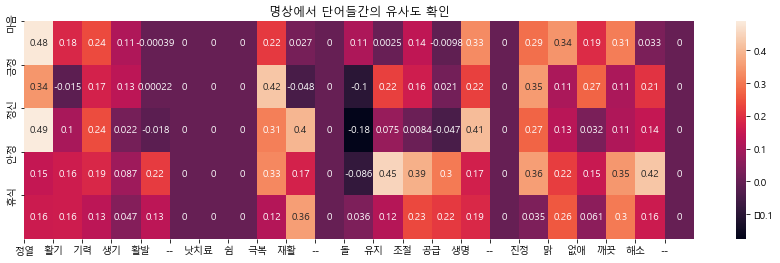

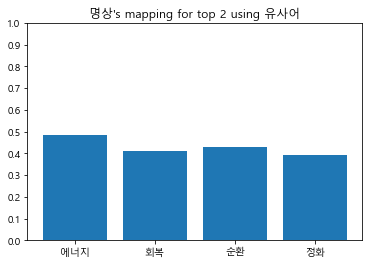

In [6]:
# 수치화의 정확하게 되었느지 확인하기 위해 heatmap으로 각 행동 단어와 차원 유사어들 사이의 유사도로 확인(wiki)
# 위 heatmap을 바탕으로 수치화 테스트 

XYZ = check_data(data)
for i in data.index[0:1]:
    XYZ.get_heatmap(i,(15,4))
    XYZ.result(i,2,True)

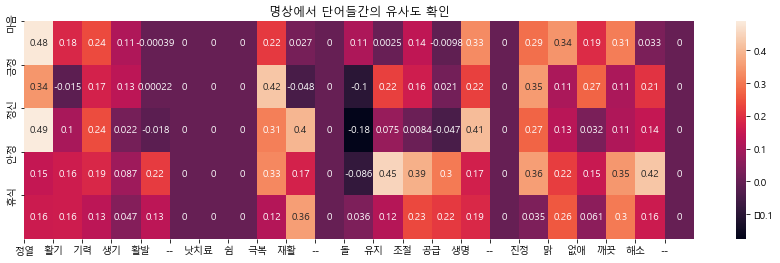

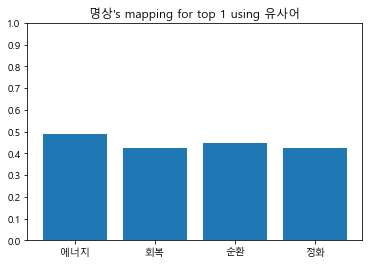

[0.48868370056152344, 0.4229516386985779, 0.4492186903953552, 0.4236677289009094]


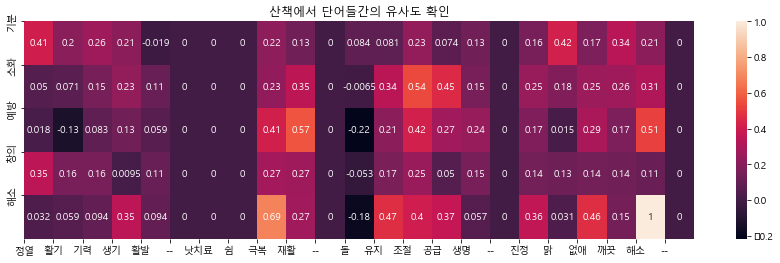

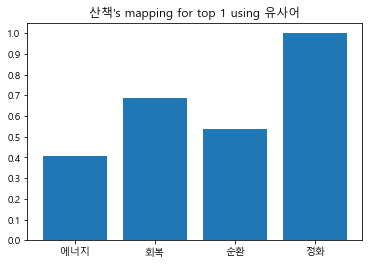

[0.40644964575767517, 0.6854312419891357, 0.5368382930755615, 1.0]


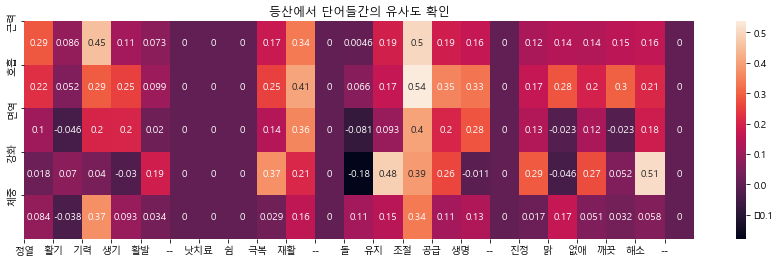

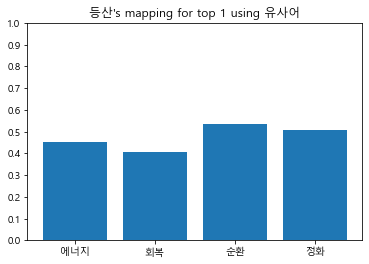

[0.4538264572620392, 0.4066994786262512, 0.5365839600563049, 0.5071028470993042]


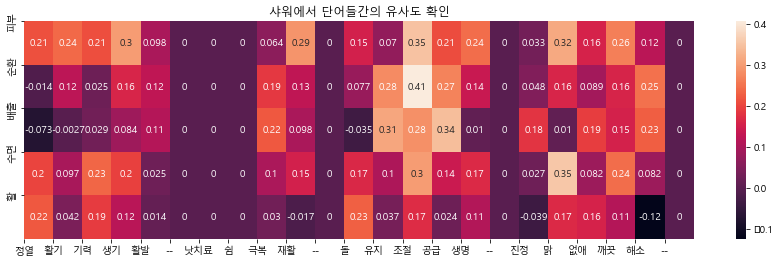

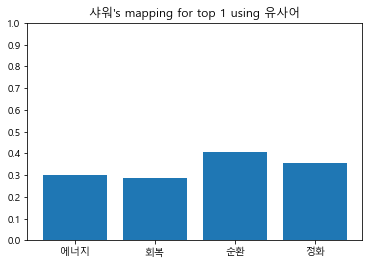

[0.2994295656681061, 0.2883305847644806, 0.40577560663223267, 0.3549930155277252]


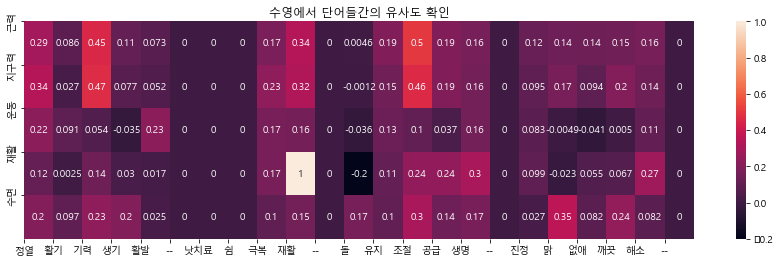

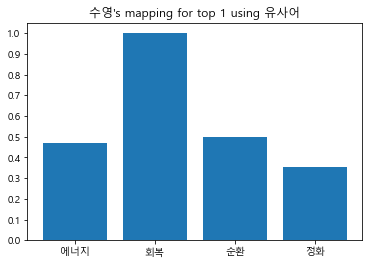

[0.4675411581993103, 1.0, 0.5002173781394958, 0.3549930155277252]


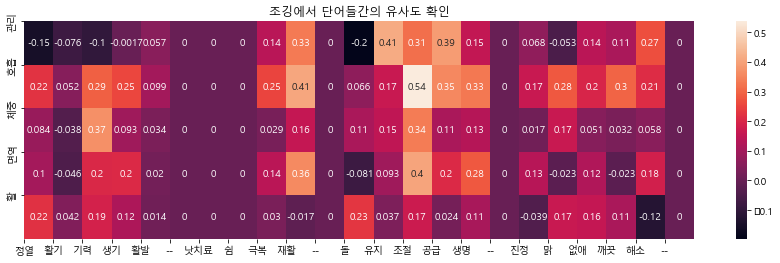

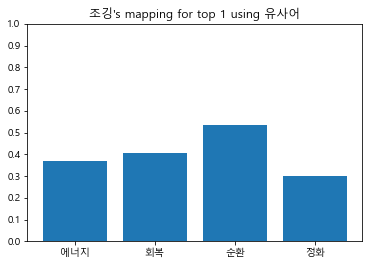

[0.3692796528339386, 0.4066994786262512, 0.5365839600563049, 0.29837900400161743]


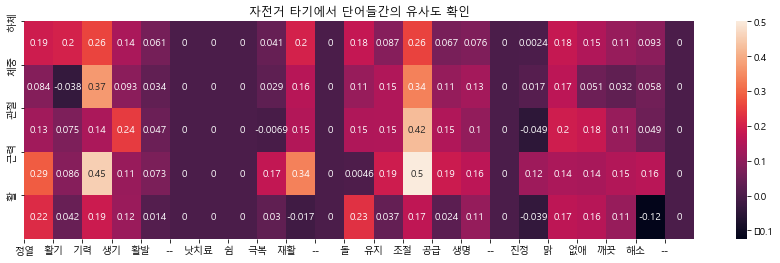

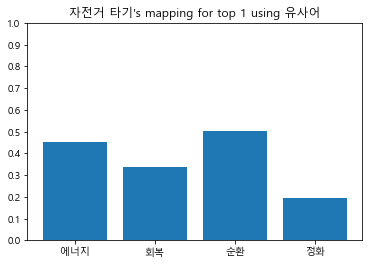

[0.4538264572620392, 0.33540216088294983, 0.5002173781394958, 0.19543322920799255]


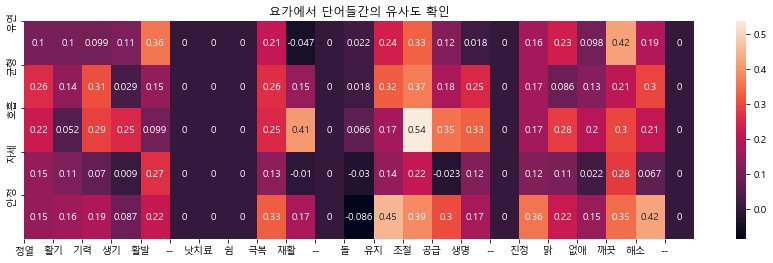

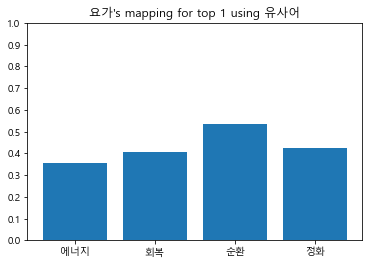

[0.355136513710022, 0.4066994786262512, 0.5365839600563049, 0.4236677289009094]


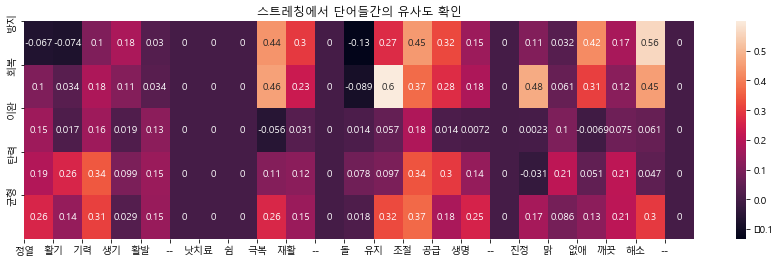

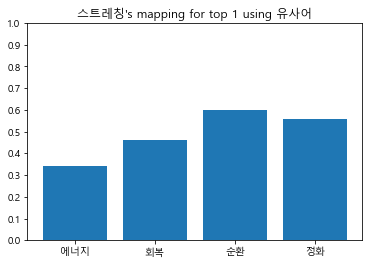

[0.34266358613967896, 0.4614623188972473, 0.5985989570617676, 0.5597227811813354]


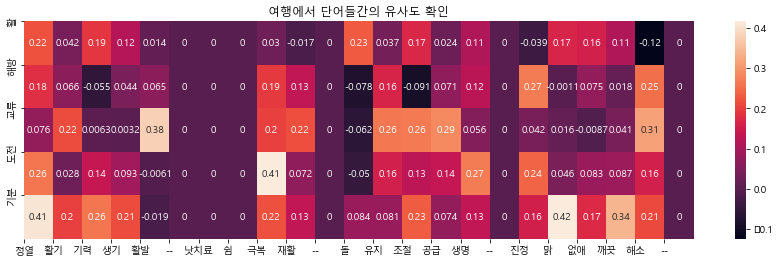

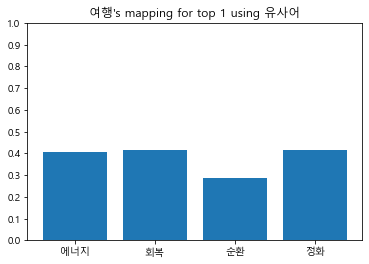

[0.40644964575767517, 0.4148305058479309, 0.28508856892585754, 0.41592249274253845]


In [7]:
# 행동 수치화(유사어 기반)
# 상위 1개 평균 
XYZ = check_data(data)
for i in data.index:
    XYZ.get_heatmap(i,(15,4))
    print(XYZ.result(i,1,True))

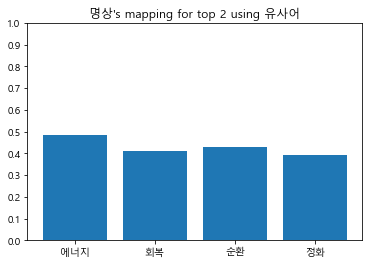

[0.4855617582798004, 0.40944957733154297, 0.4279337674379349, 0.39012061059474945]


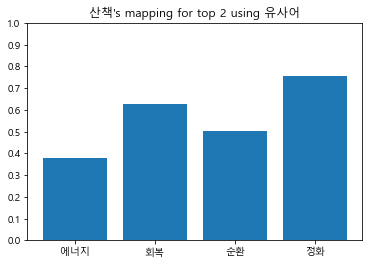

[0.3772760182619095, 0.6252224743366241, 0.501750260591507, 0.7557567059993744]


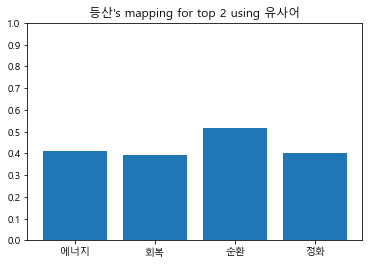

[0.4115530550479889, 0.38989537954330444, 0.5184006690979004, 0.4027409255504608]


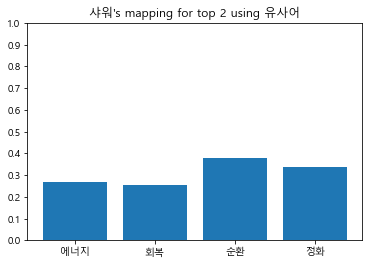

[0.26886094361543655, 0.2548903301358223, 0.37738582491874695, 0.33547696471214294]


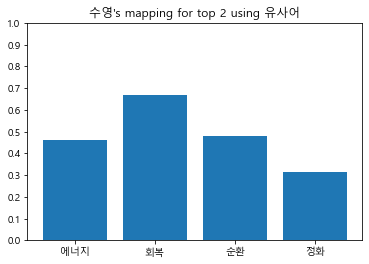

[0.46068380773067474, 0.6677010804414749, 0.47872915863990784, 0.31313444674015045]


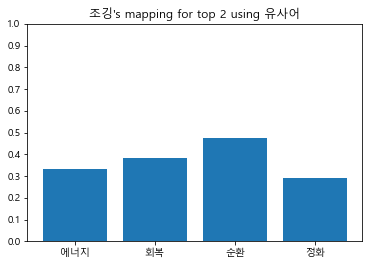

[0.3300853818655014, 0.381864070892334, 0.47550973296165466, 0.28997114300727844]


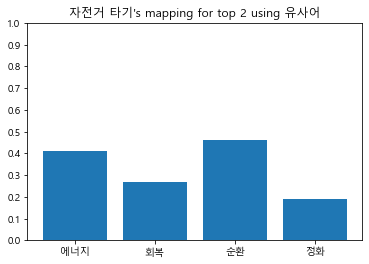

[0.4115530550479889, 0.2701107785105705, 0.46150460839271545, 0.1883792281150818]


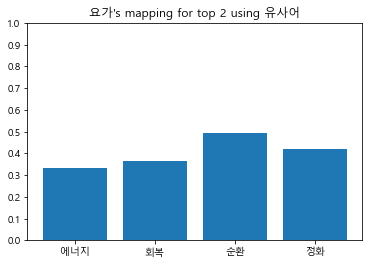

[0.33138707280158997, 0.3659587800502777, 0.4929013252258301, 0.4213559627532959]


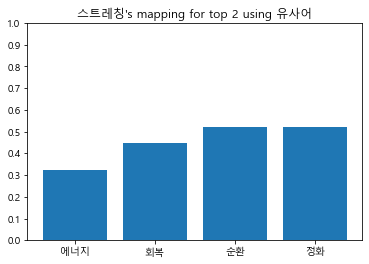

[0.32515060901641846, 0.4488336443901062, 0.5218651592731476, 0.5186566412448883]


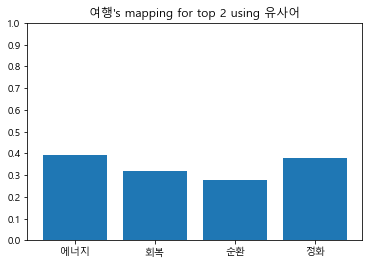

[0.3921938091516495, 0.31668412685394287, 0.27669136226177216, 0.37731461226940155]


In [8]:
# 행동 수치화(유사어 기반)
# 상위 2개 평균 
XYZ = check_data(data)
for i in data.index:
    #XYZ.get_heatmap(i,(15,4))
    print(XYZ.result(i,2,True))

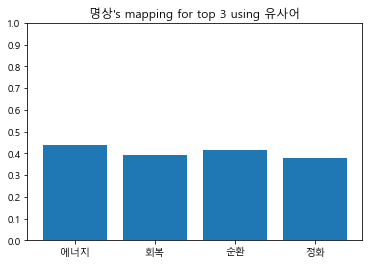

[0.43852492173512775, 0.3925278385480245, 0.41417619585990906, 0.37767810622851056]


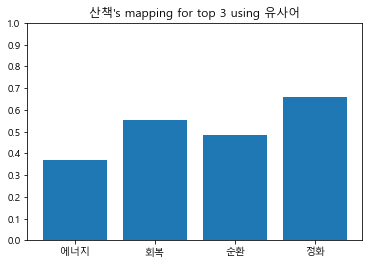

[0.3673219581445058, 0.5551063021024069, 0.4851773182551066, 0.6584712564945221]


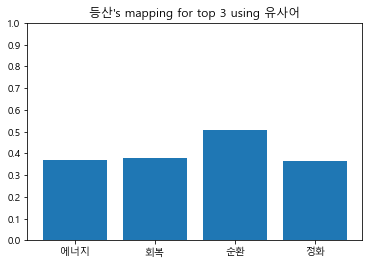

[0.37133240699768066, 0.37893980741500854, 0.5060563087463379, 0.3650062878926595]


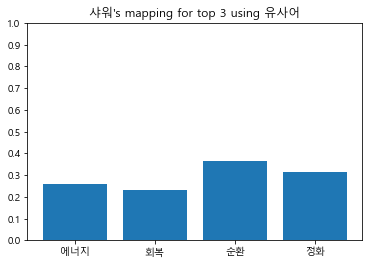

[0.25750963389873505, 0.23161072532335916, 0.3655646840731303, 0.3119376599788666]


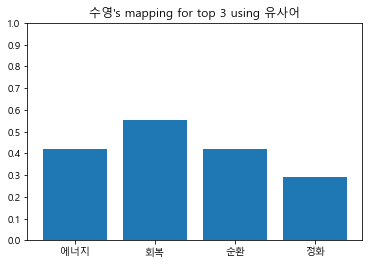

[0.4194052616755168, 0.5518180926640829, 0.41865644852320355, 0.28959516684214276]


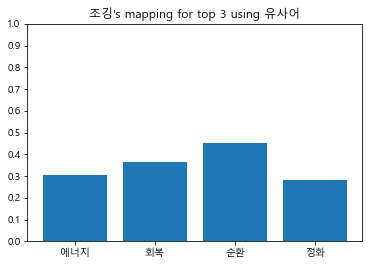

[0.3046097656091054, 0.3655404845873515, 0.4517684777577718, 0.282278835773468]


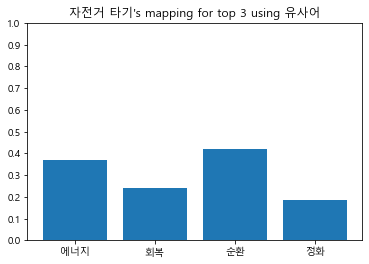

[0.3701346516609192, 0.238303080201149, 0.41953174273173016, 0.18506706754366556]


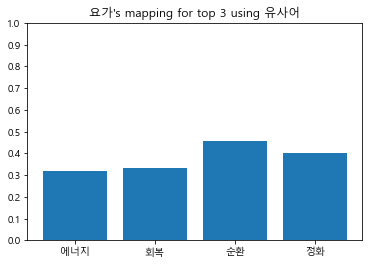

[0.31788841883341473, 0.33172576626141864, 0.4574879010518392, 0.3997618059317271]


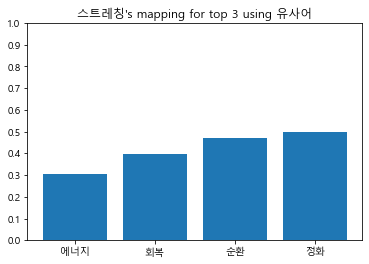

[0.3039245108763377, 0.39846505721410114, 0.47218551238377887, 0.49718759457270306]


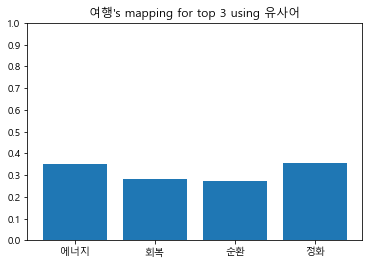

[0.34877076745033264, 0.2831324835618337, 0.272793044646581, 0.3561663130919139]


In [9]:
# 행동 수치화(유사어 기반)
# 상위 3개 평균 
XYZ = check_data(data)
for i in data.index:
    #XYZ.get_heatmap(i,(15,4))
    print(XYZ.result(i,3,True))

In [11]:
# 상위 2개 평균 사용
# 상위 N개에서 N이 커질 수록 각 데이터의 차이가 줄어듬
# 현재 사용하는 데이터도 라벨링이 되어 있어서 상위 2개 정도만 사용하면 될 것 같음
XYZ.todf(2, '../result/action_estimation.csv')

,감정,에너지,회복,순환,정화
0,명상,0.485562,0.409450,0.427934,0.390121
1,산책,0.377276,0.625222,0.501750,0.755757
2,등산,0.411553,0.389895,0.518401,0.402741
3,샤워,0.268861,0.254890,0.377386,0.335477
4,수영,0.460684,0.667701,0.478729,0.313134
5,조깅,0.330085,0.381864,0.475510,0.289971
6,자전거 타기,0.411553,0.270111,0.461505,0.188379
7,요가,0.331387,0.365959,0.492901,0.421356
8,스트레칭,0.325151,0.448834,0.521865,0.518657
9,여행,0.392194,0.316684,0.276691,0.377315
